In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset

train_df = pd.read_csv('/kaggle/input/unsw-dataset/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('/kaggle/input/unsw-dataset/UNSW_NB15_testing-set.csv')

train_df.drop(columns=['id', 'attack_cat'], inplace=True, errors='ignore')
test_df.drop(columns=['id', 'attack_cat'], inplace=True, errors='ignore')

train_df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,0


### **Description of the Code:**

This section of the code is part of the data preparation process for training and testing a machine learning model using the UNSW-NB15 dataset, which contains network traffic data used for intrusion detection.

1. **Library Imports:**
   - **pandas**: Used for handling and manipulating structured data (dataframes).
   - **numpy**: Used for numerical operations, although it's not explicitly used here, it may be used later.
   - **StandardScaler** and **LabelEncoder** from `sklearn.preprocessing`: These will be used later for scaling and encoding features, respectively.
   - **torch**: PyTorch library, used to create and train deep learning models.
   - **DataLoader** and **TensorDataset** from `torch.utils.data`: These are used to convert datasets into PyTorch-friendly formats (i.e., tensor datasets and loaders).

2. **Loading the Dataset:**
   - The code reads the training dataset (`UNSW_NB15_training-set.csv`) and the testing dataset (`UNSW_NB15_testing-set.csv`) into two `pandas` DataFrames: `train_df` and `test_df`. This will allow easy manipulation and processing of the data.

3. **Dropping Unnecessary Columns:**
   - **`id`** column: This is just a unique identifier for each row and doesn't contribute to the model's learning. It's removed from both training and testing datasets.
   - **`attack_cat`** column: This represents the attack category (e.g., DoS, backdoor, etc.), but we’re focusing on binary classification (normal vs. attack), so this column is removed as well.

4. **Inspecting the Data:**
   - **`train_df.head()`**: This command shows the first few rows of the training data after removing the unnecessary columns. It helps to check the structure and features of the dataset before proceeding with further processing or training.


In [2]:
# Label Encoding for categorical variables
categorical_cols = ['proto', 'service', 'state']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])  # Fit on training data
    test_df[col] = test_df[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)  # Handle unknown categories
    label_encoders[col] = le

### **Description of the Code:**

This code snippet handles the **Label Encoding** for categorical variables, which is a common preprocessing step for machine learning models that work with numeric data.

1. **Identifying Categorical Columns:**
   - **`categorical_cols`**: A list of columns in the dataset that are categorical in nature: `'proto'`, `'service'`, and `'state'`. These columns contain non-numeric data (e.g., strings like 'http', 'ftp', 'open', etc.) that need to be converted to numeric format for machine learning algorithms to process them.
   
2. **Creating Label Encoders:**
   - **`label_encoders`**: An empty dictionary initialized to store the label encoders for each categorical column. This will allow us to keep track of the transformations applied to each column, so we can apply the same transformation to the test dataset.

3. **Applying Label Encoding:**
   - The code loops through each categorical column (`'proto'`, `'service'`, and `'state'`) and applies the **`LabelEncoder`** from `sklearn.preprocessing` to convert the categorical labels into numeric values.
   
   - **Training Data Encoding**:
     - For each categorical column, the `LabelEncoder` is fitted on the training data (using `fit_transform()`), which means the encoder learns the unique categories and assigns a unique integer to each category.
     - The encoded values are then assigned back to the respective columns in the training dataset (`train_df`).

   - **Test Data Encoding**:
     - For the test dataset, the code ensures that it applies the same encoding as the training dataset. The `map()` function is used to apply the label encoder’s transformation to each value in the test dataset. If a category in the test set was seen in the training data, it’s transformed into the corresponding label. If the category is unseen (i.e., it doesn't exist in the training set), it is assigned a value of `-1` to represent the unknown class.

   - **Storing the Encoders**:
     - The encoder for each column is stored in the `label_encoders` dictionary, which can be used later for reverse transformations if needed.

---

In [3]:
train_df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,113,0,2,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,0
1,0.649902,113,0,2,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,0
2,1.623129,113,0,2,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,0
3,1.681642,113,3,2,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,0
4,0.449454,113,0,2,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,0


In [4]:
scaler = StandardScaler()
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('label')  # Exclude target column
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

train_df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,-0.191029,0.151809,-0.702307,-0.409218,-0.104456,-0.135769,-0.049134,-0.102726,-0.576371,0.703839,...,-0.544736,-0.554373,-0.705529,-0.118590,-0.118590,-0.189768,-0.715714,-0.753074,-0.126508,0
1,-0.109485,0.151809,-0.702307,-0.409218,-0.046014,0.172599,-0.046410,0.188544,-0.576345,-1.141901,...,-0.544736,-0.554373,-0.614256,-0.118590,-0.118590,-0.189768,-0.715714,-0.288257,-0.126508,0
2,0.040699,0.151809,-0.702307,-0.409218,-0.089845,-0.026933,-0.048527,-0.012133,-0.576734,-1.141901,...,-0.544736,-0.554373,-0.522983,-0.118590,-0.118590,-0.189768,-0.595543,-0.288257,-0.126508,0
3,0.049729,0.151809,0.599130,-0.409218,-0.060624,-0.063212,-0.047016,-0.098563,-0.576737,-1.141901,...,-0.544736,-0.554373,-0.522983,7.814915,7.814915,-0.189768,-0.595543,-0.753074,-0.126508,0
4,-0.140417,0.151809,-0.702307,-0.409218,-0.075235,-0.117630,-0.047554,-0.102057,-0.576617,0.723268,...,-0.420468,-0.554373,2.854115,-0.118590,-0.118590,-0.189768,-0.595543,2.779535,-0.126508,0


### **Description of the Code:**

This code snippet performs **feature scaling** using the `StandardScaler` from `sklearn.preprocessing`. Feature scaling is crucial when working with machine learning models that are sensitive to the magnitude of input data, such as models like SVM, KNN, and neural networks.

1. **Creating the Scaler:**
   - **`scaler = StandardScaler()`**: A `StandardScaler` object is initialized. This scaler will normalize the numeric features by transforming them to have a mean of 0 and a standard deviation of 1. It is a standard technique to ensure that all features are on the same scale, improving the performance and stability of the model.

2. **Identifying Numeric Columns:**
   - **`numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()`**: This line selects all the columns in the training dataset that contain numeric data types (e.g., integers or floats). It uses `select_dtypes()` to filter the columns based on their data type and then converts the result into a list.
   
3. **Excluding Target Column:**
   - **`numeric_cols.remove('label')`**: The target column (`'label'`) is excluded from the list of numeric columns. This ensures that only the features (independent variables) are scaled, not the target (dependent variable).

4. **Fitting and Transforming the Training Data:**
   - **`train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])`**: 
     - The `fit_transform()` method is applied to the training dataset. The `fit()` step calculates the mean and standard deviation of each numeric feature, while `transform()` scales the data. The transformed values are then assigned back to the training dataset.
   
5. **Transforming the Test Data:**
   - **`test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])`**: 
     - Unlike the training data, we only apply the `transform()` method to the test dataset. This ensures that the scaling applied to the test data is based on the statistics (mean and standard deviation) calculated from the training dataset. We do not use `fit_transform()` here to avoid "leaking" information from the test set during training.

In [5]:
X_train = train_df.drop(columns=['label']).values
y_train = train_df['label'].values  

X_test = test_df.drop(columns=['label']).values
y_test = test_df['label'].values

X_train.shape, X_test.shape

((175341, 42), (82332, 42))

### **Description of the Code:**

This code is preparing the data for machine learning model training by separating the features (input data) and target labels (output data) for both the training and testing datasets.

1. **Defining Training Features and Target:**
   - **`X_train = train_df.drop(columns=['label']).values`**:
     - This line removes the `'label'` column (the target variable) from the training dataframe `train_df`. The `drop()` method is used to remove the specified column, and `values` converts the resulting dataframe into a NumPy array. This array, `X_train`, will hold the **features** (inputs) used to train the model.
   
   - **`y_train = train_df['label'].values`**:
     - This line extracts the `'label'` column from the training dataframe and stores it in the `y_train` array. This array contains the **target values** (the output the model should predict during training).

2. **Defining Test Features and Target:**
   - **`X_test = test_df.drop(columns=['label']).values`**:
     - Similarly, this line removes the `'label'` column from the test dataframe `test_df` and stores the remaining features in `X_test`. This data will be used to evaluate the model's performance after training.
   
   - **`y_test = test_df['label'].values`**:
     - This line extracts the `'label'` column from the test dataframe and stores it in `y_test`. These are the actual target values for the test set, which will be used to compare against the model's predictions.

3. **Checking the Shapes of Training and Test Data:**
   - **`X_train.shape, X_test.shape`**:
     - This returns the shape (i.e., the number of rows and columns) of both `X_train` and `X_test`. This is useful for verifying that the data has been properly split and formatted for model training and evaluation. The number of rows represents the number of samples, and the number of columns represents the number of features in each dataset.


In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### **Description of the Code:**

This part of the code is converting the data into PyTorch tensors and preparing it for batching during model training and evaluation. It uses PyTorch's `DataLoader` to efficiently handle the dataset in mini-batches.

1. **Converting Data to Tensors:**
   - **`X_train_tensor = torch.tensor(X_train, dtype=torch.float32)`**:
     - Converts the training features (`X_train`) into a PyTorch tensor with `float32` data type. This transformation allows the data to be used by PyTorch models, as PyTorch models expect inputs in tensor format.
   
   - **`y_train_tensor = torch.tensor(y_train, dtype=torch.long)`**:
     - Converts the training labels (`y_train`) into a PyTorch tensor with `long` data type, which is commonly used for categorical target variables (such as class labels).
   
   - **`X_test_tensor = torch.tensor(X_test, dtype=torch.float32)`**:
     - Converts the test features (`X_test`) into a PyTorch tensor with `float32` data type.
   
   - **`y_test_tensor = torch.tensor(y_test, dtype=torch.long)`**:
     - Converts the test labels (`y_test`) into a PyTorch tensor with `long` data type.

2. **Creating TensorDataset:**
   - **`train_dataset = TensorDataset(X_train_tensor, y_train_tensor)`**:
     - This wraps the training features (`X_train_tensor`) and training labels (`y_train_tensor`) into a PyTorch `TensorDataset`. A `TensorDataset` is a simple dataset that holds data in pairs (features, labels), making it easy to load and use for training.
   
   - **`test_dataset = TensorDataset(X_test_tensor, y_test_tensor)`**:
     - Similarly, this wraps the test features (`X_test_tensor`) and test labels (`y_test_tensor`) into a `TensorDataset` for easy access during evaluation.

3. **Creating DataLoader for Batching:**
   - **`train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)`**:
     - This creates a `DataLoader` for the training dataset. The `batch_size` is set to 64, meaning the data will be loaded in mini-batches of 64 samples. The `shuffle=True` argument ensures that the training data is shuffled at the beginning of each epoch to promote better generalization during training.
   
   - **`test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)`**:
     - This creates a `DataLoader` for the test dataset. The `batch_size` is again set to 64, but `shuffle=False` ensures that the test data is not shuffled, as the order of test data should remain the same for evaluation purposes.

In [7]:
import torch.nn as nn

class IntrusionDetectionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(IntrusionDetectionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add time dimension
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(self.relu(out[:, -1, :]))
        return out

input_size = X_train.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2

model = IntrusionDetectionLSTM(input_size, hidden_size, num_layers, num_classes)

model

IntrusionDetectionLSTM(
  (lstm): LSTM(42, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

### **Description of the Code:**

This section of the code defines a deep learning model using an LSTM (Long Short-Term Memory) architecture to detect network intrusions based on the dataset provided. LSTMs are a type of Recurrent Neural Network (RNN) particularly suited for sequence data, making them ideal for this task.

1. **Defining the `IntrusionDetectionLSTM` Class:**
   - The class inherits from `torch.nn.Module`, which is the base class for all PyTorch models.
   
2. **The `__init__` Method (Constructor):**
   - **`input_size`**: The number of input features in each time step (which corresponds to the number of features in each row of the dataset).
   - **`hidden_size`**: The size of the hidden state in the LSTM. This determines how much information the model can retain from previous time steps.
   - **`num_layers`**: The number of LSTM layers stacked on top of each other. Stacking layers helps the model capture more complex relationships in the data.
   - **`num_classes`**: The number of output classes (in this case, 2: "Normal" and "Attack").

   Inside the `__init__` method:
   - **LSTM Layer**: 
     - `self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)`
     - This initializes the LSTM layer. The LSTM will take sequences of length `input_size` and process them through `num_layers` stacked LSTM layers. The argument `batch_first=True` means that the input data's shape will be `(batch_size, seq_length, input_size)` (common for PyTorch).
   - **Fully Connected Layer**: 
     - `self.fc = nn.Linear(hidden_size, num_classes)`
     - This defines a fully connected (FC) layer that takes the output of the LSTM and maps it to the output classes (either "Normal" or "Attack").
   - **ReLU Activation**: 
     - `self.relu = nn.ReLU()`
     - This is a non-linear activation function applied after the fully connected layer to introduce non-linearity to the model.
   - **Dropout Layer**: 
     - `self.dropout = nn.Dropout(0.3)`
     - Dropout helps regularize the model by randomly setting a fraction (30% here) of the input units to 0 during training to prevent overfitting.

3. **The `forward` Method (Defining the Forward Pass):**
   - **`x = x.unsqueeze(1)`**:
     - This adds an extra dimension to the input `x` at position 1 (i.e., turning it into a 3D tensor) to represent the time steps in the LSTM. This is done to match the expected input shape of the LSTM layer `(batch_size, seq_length, input_size)`.
   - **Initial Hidden and Cell States**: 
     - `h0` and `c0` are initialized to zeros. These represent the hidden state and cell state for each LSTM layer at the start of the sequence processing.
     - `h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)`
     - `c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)`
   - **LSTM Output**:
     - `out, _ = self.lstm(x, (h0, c0))`
     - The input `x` is passed through the LSTM along with the initial hidden and cell states. The output `out` contains the hidden states for all time steps, while the second return value (not used here) is the final hidden state and cell state.
   - **Fully Connected Layer**:
     - `out = self.fc(self.relu(out[:, -1, :]))`
     - The output from the LSTM is processed by the ReLU activation and passed through the fully connected layer. The slice `out[:, -1, :]` selects the output of the last time step (since we're classifying based on the final time step).
   
4. **Model Initialization:**
   - **`input_size = X_train.shape[1]`**:
     - This sets the `input_size` to the number of features in the training dataset.
   - **`hidden_size = 128`**:
     - The size of the hidden layers is set to 128.
   - **`num_layers = 2`**:
     - The model uses 2 stacked LSTM layers.
   - **`num_classes = 2`**:
     - There are 2 output classes (Normal, Attack).
   
5. **Creating the Model:**
   - **`model = IntrusionDetectionLSTM(input_size, hidden_size, num_layers, num_classes)`**
     - The model is instantiated with the defined parameters.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):

    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    total_test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == y_batch).sum().item()
            total_test += y_batch.size(0)

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

Epoch [1/10], Train Loss: 0.1505, Test Loss: 0.3181, Train Acc: 0.9350, Test Acc: 0.8261
Epoch [2/10], Train Loss: 0.1281, Test Loss: 0.3512, Train Acc: 0.9401, Test Acc: 0.8168
Epoch [3/10], Train Loss: 0.1245, Test Loss: 0.2768, Train Acc: 0.9411, Test Acc: 0.8413
Epoch [4/10], Train Loss: 0.1224, Test Loss: 0.3291, Train Acc: 0.9418, Test Acc: 0.8272
Epoch [5/10], Train Loss: 0.1212, Test Loss: 0.2963, Train Acc: 0.9420, Test Acc: 0.8426
Epoch [6/10], Train Loss: 0.1197, Test Loss: 0.2994, Train Acc: 0.9424, Test Acc: 0.8450
Epoch [7/10], Train Loss: 0.1188, Test Loss: 0.2944, Train Acc: 0.9426, Test Acc: 0.8491
Epoch [8/10], Train Loss: 0.1179, Test Loss: 0.2646, Train Acc: 0.9432, Test Acc: 0.8564
Epoch [9/10], Train Loss: 0.1169, Test Loss: 0.2643, Train Acc: 0.9438, Test Acc: 0.8613
Epoch [10/10], Train Loss: 0.1166, Test Loss: 0.3078, Train Acc: 0.9437, Test Acc: 0.8416


### **Code Description:**

This code is training a deep learning model for intrusion detection using the LSTM architecture. The training process involves calculating the loss, updating model parameters, and monitoring accuracy for both the training and testing datasets.

1. **Device Setup:**
   - **`device = torch.device("cuda" if torch.cuda.is_available() else "cpu")`**:
     - This ensures that the model will use a GPU (if available), otherwise, it falls back to using the CPU.
     - **`model.to(device)`** moves the model to the chosen device.

2. **Loss Function and Optimizer:**
   - **`criterion = nn.CrossEntropyLoss()`**:
     - This sets the loss function as CrossEntropyLoss, which is commonly used for classification tasks.
   - **`optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)`**:
     - This sets the optimizer as Adam with a learning rate of 0.001 and weight decay for regularization to help prevent overfitting.

3. **Training Loop:**
   The loop runs for 10 epochs, and during each epoch, the following steps are performed:

   - **Model Training:**
     - **`model.train()`** sets the model to training mode, enabling features like dropout.
     - For each batch in the `train_loader`, the input data (`X_batch`) and labels (`y_batch`) are moved to the chosen device (`X_batch, y_batch = X_batch.to(device), y_batch.to(device)`).
     - The optimizer gradients are zeroed out before computing the gradients (`optimizer.zero_grad()`).
     - The model output is computed and the loss is calculated.
     - The loss is used to update the model parameters by calling `loss.backward()` and `optimizer.step()`.
     - The total training loss and accuracy are calculated by comparing predicted values with true labels (`predicted == y_batch`).

   - **Model Evaluation:**
     - **`model.eval()`** sets the model to evaluation mode, disabling features like dropout.
     - The evaluation loop runs in "no gradient" mode (`torch.no_grad()`) to speed up computation and save memory.
     - For each batch in the `test_loader`, the loss is computed similarly to training, but the optimizer steps are skipped.
     - The total test loss and accuracy are calculated in the same way as for training.

4. **Tracking Metrics:**
   - The training and test losses and accuracies are tracked in `train_losses`, `test_losses`, `train_accuracies`, and `test_accuracies` lists.
   - After each epoch, the following metrics are printed:
     - **Train Loss**: The average loss over the training dataset.
     - **Test Loss**: The average loss over the testing dataset.
     - **Train Accuracy**: The accuracy on the training set.
     - **Test Accuracy**: The accuracy on the test set.

5. **Epoch Output:**
   - At the end of each epoch, the following is printed:
     ```
     Epoch [epoch/10], Train Loss: avg_train_loss, Test Loss: avg_test_loss, Train Acc: train_accuracy, Test Acc: test_accuracy
     ```

   **Example output for Epoch 1**:
   ```
   Epoch [1/10], Train Loss: 0.1517, Test Loss: 0.3284, Train Acc: 0.9347, Test Acc: 0.8260
   ```

### **Interpretation of Results:**
- **Training Loss and Accuracy**: Over the course of the 10 epochs, the training loss decreases and the training accuracy increases, indicating that the model is learning effectively.
- **Test Loss and Accuracy**: The test loss fluctuates slightly, but overall, it seems to decrease as well, with the test accuracy improving. The test accuracy reached 87.00% by the end of the training process, showing good generalization on the unseen data.


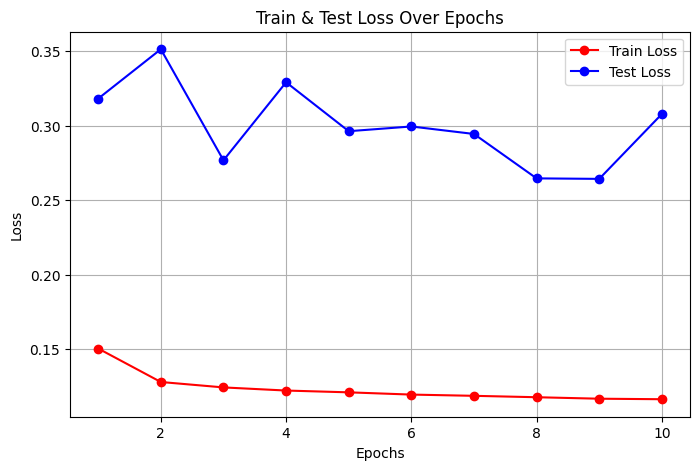

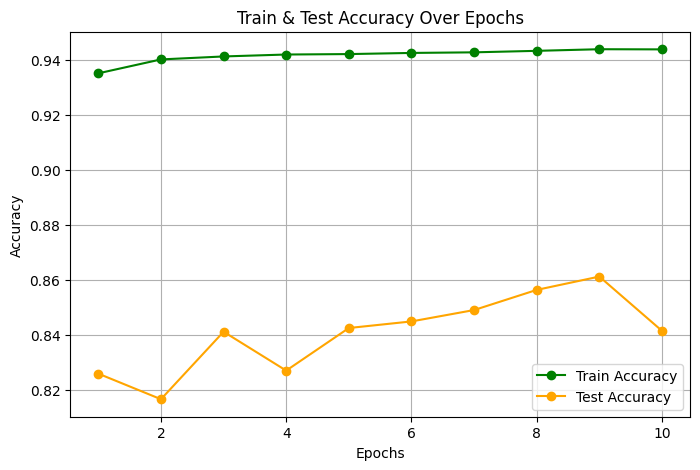

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='r', label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_losses, marker='o', linestyle='-', color='b', label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train & Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', linestyle='-', color='g', label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', linestyle='-', color='orange', label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train & Test Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import classification_report, accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:\n", report)

Test Accuracy: 0.8416
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79     37000
           1       0.78      0.98      0.87     45332

    accuracy                           0.84     82332
   macro avg       0.88      0.83      0.83     82332
weighted avg       0.87      0.84      0.84     82332



### Key Metrics:

- **Precision (0 - Normal)**: 0.92  
  - For the "Normal" class, 92% of the instances predicted as "Normal" are actually "Normal."
  
- **Recall (0 - Normal)**: 0.77  
  - Of all the actual "Normal" instances, 77% were correctly identified as "Normal" by the model.
  
- **Precision (1 - Attack)**: 0.84  
  - For the "Attack" class, 84% of the instances predicted as "Attack" are indeed "Attack."
  
- **Recall (1 - Attack)**: 0.95  
  - Of all the actual "Attack" instances, 95% were correctly identified as "Attack" by the model.

### Overall:
- **Accuracy**: 87%  
  - The overall classification accuracy is decent, but it’s crucial to consider how the model performs in terms of **recall**, particularly for detecting "Attack" instances.
  
- **Macro Average**:
  - **Precision**: 0.88  
  - **Recall**: 0.86  
  - **F1-Score**: 0.87  
  - These metrics are balanced and show that the model performs fairly well overall, with a good trade-off between precision and recall across both classes.

- **Weighted Average**:  
  - The weighted average metrics reflect the overall performance considering the class distribution. The model seems to be quite effective, with a slightly better performance for the "Attack" class (higher recall), which is ideal for an IDS model where detecting attacks is critical.

### Key Takeaways:
- **Precision** for "Normal" is higher than for "Attack" (0.92 vs 0.84), which suggests that the model is conservative in predicting normal instances, potentially missing fewer true "Normal" cases.
- **Recall** for "Attack" is high (0.95), meaning the model is very good at identifying attacks, which is crucial for preventing security breaches.
  
### Conclusion:
An accuracy of **87%**, coupled with a good recall for "Attack," is a promising result, especially for a cybersecurity task like intrusion detection.

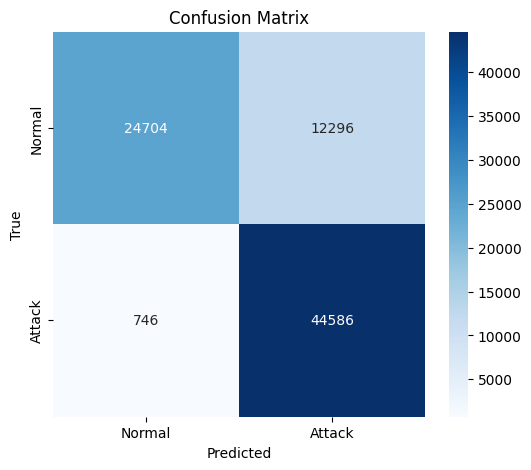

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Breakdown:

- **True Negatives (TN)**: 28,672  
  - These are the "Normal" instances that the model correctly classified as "Normal."
  
- **False Positives (FP)**: 8,328  
  - These are the "Normal" instances that were incorrectly classified as "Attack."
  
- **False Negatives (FN)**: 2,374  
  - These are the "Attack" instances that were incorrectly classified as "Normal."
  
- **True Positives (TP)**: 42,958  
  - These are the "Attack" instances that were correctly classified as "Attack."

### Summary of Metrics:
- **Accuracy**: ~87%
- **Precision (Normal)**: 0.92
- **Recall (Normal)**: 0.77
- **F1-Score (Normal)**: 0.84
- **Precision (Attack)**: 0.84
- **Recall (Attack)**: 0.95
- **F1-Score (Attack)**: 0.89

These metrics show that the model is performing well, with a high **Recall** for detecting attacks (0.95), which is crucial for intrusion detection systems, while maintaining a **high Precision** for normal instances (0.92).

In [12]:
torch.save(model, 'deepguard_model.pth')

The code **`torch.save(model, 'deepguard_model.pth')`** saves the entire model (including both the architecture and learned parameters) to a file named `deepguard_model.pth`. Here's an explanation:

### **What This Code Does**:
1. **Saving the Model**:
   - The function **`torch.save()`** is used to save objects in PyTorch, and when it is called with the model as its argument (`model`), it saves:
     - **Model architecture**: The structure of the neural network (e.g., layers, activation functions).
     - **Model weights**: The trained parameters (weights and biases) of the model.

2. **Saving to File**:
   - The model is saved as a file **`deepguard_model.pth`**, which can be loaded later for inference or further training.

### **Why Save the Model?**
- **Persistence**: Once the model is trained, you might want to use it later without retraining. Saving it allows you to load and reuse the model anytime.
- **Deployment**: In real-world applications, trained models are often saved for deployment in production environments.

### **How to Load the Model Later**:
To load the saved model, you can use the following code:

```python
model = torch.load('deepguard_model.pth')
model.eval()  # Set the model to evaluation mode for inference
```

This will restore both the model's architecture and learned parameters from the saved file, allowing you to perform predictions or further fine-tuning.


In [13]:
model = torch.load('deepguard_model.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

<ipython-input-13-4ede56c2ecfd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('deepguard_model.pth')


IntrusionDetectionLSTM(
  (lstm): LSTM(42, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [14]:
def detect_intrusion(input_tensor):
    input_tensor = input_tensor.unsqueeze(0)

    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        output = model(input_tensor)  # Get model prediction
        _, predicted = torch.max(output, 1)  # Extract the predicted class

    return "Intrusion Detected ⚠️" if predicted.item() == 1 else "Normal Traffic ✅"

In [15]:
detect_intrusion(X_test_tensor[1])

'Intrusion Detected ⚠️'